# Import, Init

In [1]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nz_4r6xe because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  
 	X_train len -->  1997 y_train len -->  1997 
 	X_test len -->  1996 y_test len -->  1996


In [4]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY',
       'PRICE_UP'],
      dtype='object')

In [5]:
nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
                           inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
                            inplace=True, errors='ignore')
nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'PRICE_UP'],
      dtype='object')

# Preparing data

#### Swapping (the trial issue)

In [6]:
tmp = nn_manager_cut.X_test.copy()
nn_manager_cut.X_train = nn_manager_cut.X_test.copy()
nn_manager_cut.X_train = tmp.copy()

tmp = nn_manager_cut.y_test.copy()
nn_manager_cut.y_train = nn_manager_cut.y_test.copy()
nn_manager_cut.y_test = tmp.copy()

nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0]

(1996, 1996)

#### Keeping Left-off Samples Aside

In [7]:
left_off_days = 7
left_off_X = nn_manager_cut.X_train[-left_off_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-left_off_days]

left_off_y = nn_manager_cut.y_train[-left_off_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-left_off_days]

nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0]

(1989, 1996)

In [8]:
# left_off_X

## Normalizing

In [9]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

(
    nn_manager_cut.X_test_normalized[:2], 
    nn_manager_cut.X_test_transformed
)

(array([[-0.77416462, -0.7841841 , -0.24376725, -0.34050198, -0.32759468,
         -1.02589502, -0.87667263,  1.88288288, -1.        ],
        [-0.77454719, -0.78467993, -0.247165  , -0.22390896, -0.35014558,
         -0.89834477, -0.87553525,  0.96396396, -1.        ]]),
 None)

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [10]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=3))

self.training_seq_params -->  {'seq_len': 3, 'n_features': 9}
self.X_train_shape -->  [3, 9]
self.X_test_shape -->  [3, 9]


True

In [11]:
nn_manager_cut.unroll_train_test_to_sequences()

True

In [12]:
nn_manager_cut.X_test_unrolled[0]

array([[-0.77416462, -0.7841841 , -0.24376725, -0.34050198, -0.32759468,
        -1.02589502, -0.87667263,  1.88288288, -1.        ],
       [-0.77454719, -0.78467993, -0.247165  , -0.22390896, -0.35014558,
        -0.89834477, -0.87553525,  0.96396396, -1.        ],
       [-0.77151055, -0.78423495, -0.06290083, -0.05973189, -0.30794577,
        -0.91857152, -0.87489209,  1.32432432,  0.        ]])

In [13]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[-0.77454719, -0.78467993, -0.247165  , -0.22390896, -0.35014558,
        -0.89834477, -0.87553525,  0.96396396, -1.        ],
       [-0.77151055, -0.78423495, -0.06290083, -0.05973189, -0.30794577,
        -0.91857152, -0.87489209,  1.32432432,  0.        ],
       [-0.77086497, -0.78194648, -0.14548736, -0.25915754, -0.32487865,
        -1.19885281, -0.87470143,  2.18918919, -1.        ]])

In [14]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(            Price
 Date             
 2016-01-05  431.2
 2016-01-06  430.8
 2016-01-07  457.0
 2016-01-08  452.9
 2016-01-09  448.3
 2016-01-10  446.2,
 array([[452.9],
        [448.3],
        [446.2],
        [447.7],
        [445. ],
        [432.2]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [15]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [16]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(3, 9)

In [17]:
# LSTM Architecture for hard periods train-test split

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(
        LSTM(120, 
            activation=LeakyReLU(alpha=0.3), 
            kernel_initializer=weights_init, 
#                     return_sequences=True,
            ),
        input_shape=input_model_shape,
        ),
         

#     Bidirectional(LSTM(400,                        
#                        activation=LeakyReLU(alpha=0.3), 
#                        return_sequences=True,                       
#             )),
   

#     Dense(100),
#     Dense(15),
#     Dense(100, 
#           kernel_initializer=weights_init
#          ),
    Dense(100, 
          kernel_initializer=weights_init
         ),
    Dense(50, 
          kernel_initializer=weights_init
         ),
    Dense(25, 
          kernel_initializer=weights_init
         ),
    Dense(1)
]

In [18]:
nn_manager_cut.X_train_unrolled.shape

(1986, 3, 9)

### Compiling Model with the chosen Architecture

In [19]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=3e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 240)               124800    
_________________________________________________________________
dense (Dense)                (None, 100)               24100     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 155,251
Trainable params: 155,251
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [20]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1986, 3, 9], [1993, 3, 9])

CPU times: user 4min 9s, sys: 22.4 s, total: 4min 31s
Wall time: 1min 59s


(0.0, 2000.0)

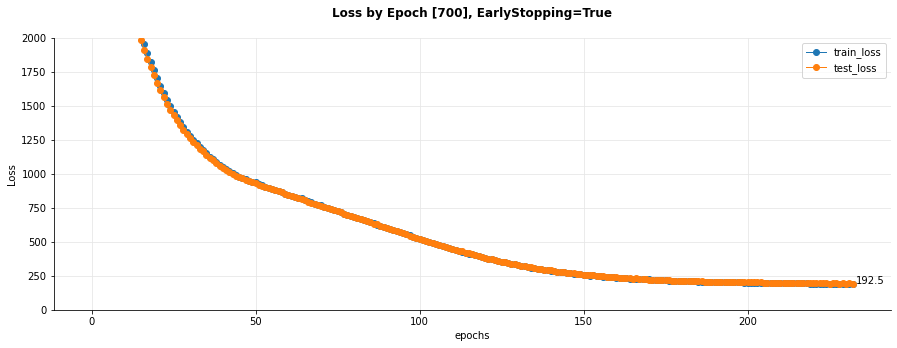

In [21]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

# Saving Model

In [22]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_191_Bidi_3d')

In [23]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

### Plotting 

In [24]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.03.01'", "Date<='2018.03.21'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [25]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [26]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [27]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [28]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [29]:
# nn_manager_cut.y_test_unrolled[:3]

In [30]:
# nn_manager_cut.y_pred[:3]

In [31]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]

# Conclusion on LSTM Model: